In [85]:
# Install xgboost4j JAR
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j/0.90/xgboost4j-0.90.jar

--2023-12-09 07:43:31--  https://repo1.maven.org/maven2/ml/dmlc/xgboost4j/0.90/xgboost4j-0.90.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2353013 (2.2M) [application/java-archive]
Saving to: ‘xgboost4j-0.90.jar’

xgboost4j-0.90.jar  100%[===================>]   2.24M  --.-KB/s    in 0.06s   

2023-12-09 07:43:31 (40.8 MB/s) - ‘xgboost4j-0.90.jar’ saved [2353013/2353013]



In [86]:
# Install xgboost4j-Spark JAR
!wget https://repo1.maven.org/maven2/ml/dmlc/xgboost4j-spark/0.90/xgboost4j-spark-0.90.jar

--2023-12-09 07:43:33--  https://repo1.maven.org/maven2/ml/dmlc/xgboost4j-spark/0.90/xgboost4j-spark-0.90.jar
Resolving repo1.maven.org (repo1.maven.org)... 199.232.192.209, 199.232.196.209, 2a04:4e42:4c::209, ...
Connecting to repo1.maven.org (repo1.maven.org)|199.232.192.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429101 (419K) [application/java-archive]
Saving to: ‘xgboost4j-spark-0.90.jar’

xgboost4j-spark-0.9 100%[===================>] 419.04K  --.-KB/s    in 0.03s   

2023-12-09 07:43:33 (14.5 MB/s) - ‘xgboost4j-spark-0.90.jar’ saved [429101/429101]



In [87]:
!pip install pyspark
!pip install xgboost

!pip install google-cloud-storage

!pip install fuzzywuzzy
!pip install python-Levenshtein
!pip install newspaper3k nltk
!pip install googlesearch-python

!pip install pmdarima
!pip install missingno
!pip install --upgrade yfinance

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_date, unix_timestamp
from pyspark.sql.types import StringType, StructType, StructField, FloatType
import yfinance as yf
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import unix_timestamp, when
from pyspark.ml.stat import Correlation

from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from google.cloud import storage
from google.colab import files

from fuzzywuzzy import fuzz
from newspaper import Article, ArticleException
from googlesearch import search
import nltk
import requests
from bs4 import BeautifulSoup
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn import metrics
import statsmodels.api as sm
from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import scipy.stats
import numpy as np


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [89]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [90]:
# Create Spark Session
spark = SparkSession.builder.appName("NiftyPrediction").config("spark.jars", "/content/xgboost4j-0.90.jar,/content/xgboost4j-spark-0.90.jar").getOrCreate()

# Define Nifty symbol
symbol = "INFY"

# Download Nifty data for INFY
data = yf.download(symbol, period="max")

# Access and convert date
data["Date"] = data.index.to_series().dt.strftime("%Y-%m-%d")

# Convert data to Spark DataFrame
data_df = spark.createDataFrame(data)

# Convert Date to date type and create timestamps
data_df = data_df.withColumn("Date", unix_timestamp(col("Date"), "yyyy-MM-dd"))
data_df = data_df.orderBy(col("Date").desc())

# Separate features (date) and label (closing price)
features = ['Open']
label = "Close"

# Convert features to a single vector
assembler = VectorAssembler(inputCols=features, outputCol="features")
prepared_data = assembler.transform(data_df)

# Get the last 20% of the data
num_data_points = prepared_data.count()
test_data_size = int(num_data_points * 0.2)
testing_data = prepared_data.orderBy(col("Date").desc()).limit(test_data_size)

# Remaining data is training data
training_data = prepared_data.subtract(testing_data)

print("Training data size:", training_data.count())
print("Testing data size:", testing_data.count())


[*********************100%%**********************]  1 of 1 completed
Training data size: 4984
Testing data size: 1245


In [91]:
data_df.head(10)

[Row(Open=17.889999389648438, High=17.93000030517578, Low=17.739999771118164, Close=17.889999389648438, Adj Close=17.889999389648438, Volume=4581100, Date=1701993600),
 Row(Open=17.670000076293945, High=17.709999084472656, Low=17.579999923706055, Close=17.639999389648438, Adj Close=17.639999389648438, Volume=3340000, Date=1701907200),
 Row(Open=17.799999237060547, High=17.860000610351562, Low=17.65999984741211, Close=17.690000534057617, Adj Close=17.690000534057617, Volume=6891300, Date=1701820800),
 Row(Open=17.59000015258789, High=17.709999084472656, Low=17.389999389648438, Close=17.459999084472656, Adj Close=17.459999084472656, Volume=5016100, Date=1701734400),
 Row(Open=17.84000015258789, High=17.8799991607666, Low=17.639999389648438, Close=17.690000534057617, Adj Close=17.690000534057617, Volume=5588600, Date=1701648000),
 Row(Open=17.469999313354492, High=17.75, Low=17.43000030517578, Close=17.729999542236328, Adj Close=17.729999542236328, Volume=4766000, Date=1701388800),
 Row(O

Finding correlation

In [92]:
temp_features = ['Date', 'Open', 'Close']

# Convert features to a single vector
assembler = VectorAssembler(inputCols=temp_features, outputCol="features")
temp_prepared_data = assembler.transform(data_df)


# Calculate the correlation matrix
corr_matrix = Correlation.corr(temp_prepared_data, "features").head()

# Extract the correlation matrix as a NumPy array
corr_array = corr_matrix[0].toArray()

# Get the correlation of features with the "Close" column
target_corr = corr_array[-1, :-1]

# Convert the correlation values to Python float
target_corr = [float(value) for value in target_corr]

# Create a schema for the correlation DataFrame
schema = StructType([
    StructField("Feature", StringType(), True),
    StructField("Correlation", FloatType(), True)
])

# Create a Spark DataFrame for the correlation with "Close"
target_corr_df = spark.createDataFrame(zip(features, target_corr), schema=schema)

# Show the correlation DataFrame
target_corr_df.show(truncate=False)

+-------+-----------+
|Feature|Correlation|
+-------+-----------+
|Open   |0.83526963 |
+-------+-----------+



# Start ML models

### Import required performance metrics for ML models

In [93]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from math import sqrt

### Linear Regression

In [94]:
from pyspark.ml.regression import LinearRegression

# Create a LinearRegression object
lin_reg = LinearRegression(labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Train the model
model = lin_reg.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)


In [95]:
predicted_values = predictions.select("prediction").toPandas()["prediction"]
actual_values = testing_data.toPandas()['Close']

In [96]:
mse = mean_squared_error(actual_values, predicted_values)
rmse = sqrt(mean_squared_error(actual_values, predicted_values))
r2 = r2_score(actual_values, predicted_values)
mae = mean_absolute_error(actual_values, predicted_values)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 1.9626759546188164
Root Mean Squared Error (RMSE): 1.4009553721010588
R2 score: 0.9109968890106582
Mean Absolute Error (MAE): 1.270181149048217


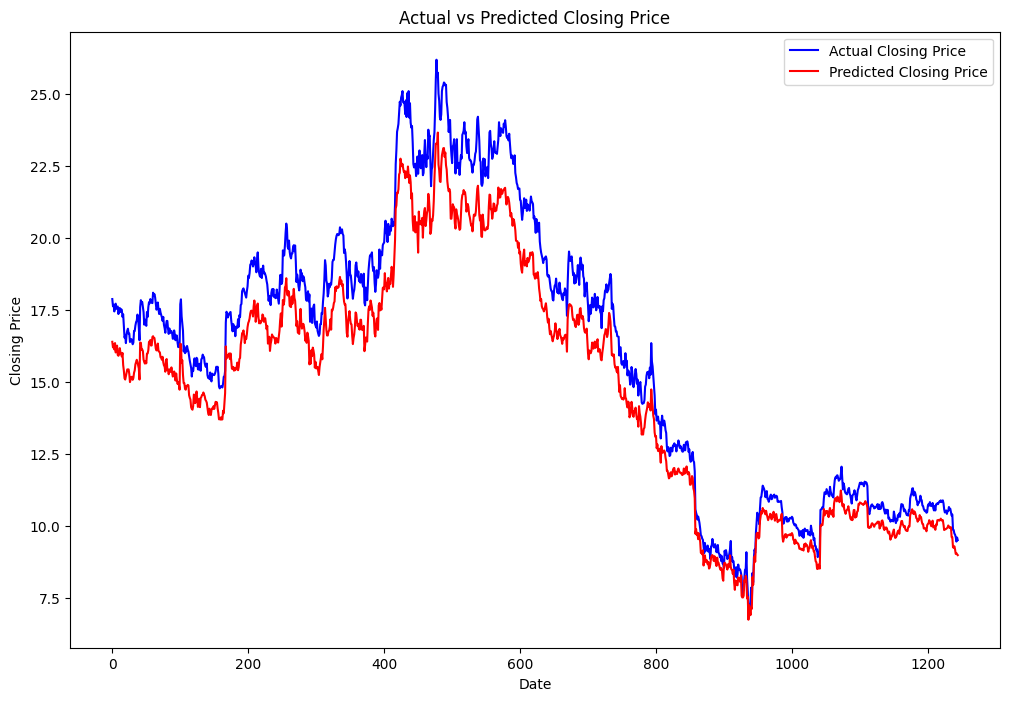

In [97]:
plt.figure(figsize=(12, 8))
plt.plot(actual_values, label="Actual Closing Price", color="blue")
plt.plot(predicted_values, label="Predicted Closing Price", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

### RandomForest Model

In [98]:
# Create a Randomforestclassifier object
rf = RandomForestClassifier(labelCol='Close', featuresCol="features", numTrees=50, maxDepth=5)

# Train the model
prepared_data_with_int = training_data.withColumn("Close", col("Close").cast("integer"))
model = rf.fit(prepared_data_with_int)

# Make predictions on the testing data
predictions = model.transform(testing_data)

In [99]:
predicted_values_rf = predictions.select("prediction").toPandas()["prediction"]
actual_values_rf = testing_data.toPandas()['Close']

In [100]:
mse = mean_squared_error(actual_values_rf, predicted_values_rf)
rmse = sqrt(mean_squared_error(actual_values_rf, predicted_values_rf))
r2 = r2_score(actual_values_rf, predicted_values_rf)
mae = mean_absolute_error(actual_values_rf, predicted_values_rf)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 71.6907730896234
Root Mean Squared Error (RMSE): 8.467040397306688
R2 score: -2.251021555133233
Mean Absolute Error (MAE): 7.0966827323637816


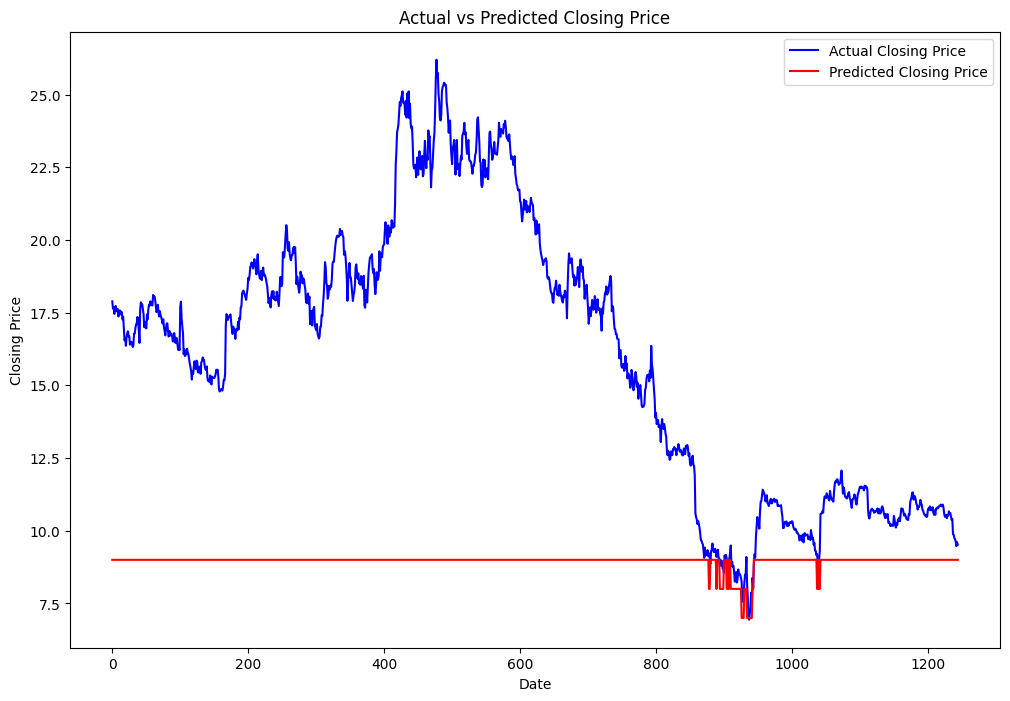

In [101]:
plt.figure(figsize=(12, 8))
plt.plot(actual_values_rf, label="Actual Closing Price", color="blue")
plt.plot(predicted_values_rf, label="Predicted Closing Price", color="red")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

### XGBoost model

In [102]:
# Import necessary libraries
from xgboost.spark import SparkXGBRegressor
from pyspark.sql.functions import col

# Define the objective and random state
objective = "reg:squarederror"
random_state = 42

# Define the label column for both datasets
df_train_label = training_data.select("Close")
df_test_label = testing_data.select("Close")

# Create an XGBoost regressor
xgboost = SparkXGBRegressor(features_col="features",
  label_col="Close",
  num_workers=2)

# Train the model
model = xgboost.fit(training_data)

# Make predictions
predictions = model.transform(testing_data)



INFO:XGBoost-PySpark:Running xgboost-2.0.2 on 2 workers with
	booster params: {'objective': 'reg:squarederror', 'device': 'cpu', 'nthread': 1}
	train_call_kwargs_params: {'verbose_eval': True, 'num_boost_round': 100}
	dmatrix_kwargs: {'nthread': 1, 'missing': nan}
INFO:XGBoost-PySpark:Finished xgboost training!


In [103]:
predicted_values_xg = predictions.select("prediction").toPandas()["prediction"]
actual_values_xg = testing_data.toPandas()['Close']

In [104]:
mse = mean_squared_error(actual_values_xg, predicted_values_xg)
rmse = sqrt(mean_squared_error(actual_values_xg, predicted_values_xg))
r2 = r2_score(actual_values_xg, predicted_values_xg)
mae = mean_absolute_error(actual_values_xg, predicted_values_xg)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 52.93589360376884
Root Mean Squared Error (RMSE): 7.275705711734693
R2 score: -1.400528320861436
Mean Absolute Error (MAE): 5.746478779727675


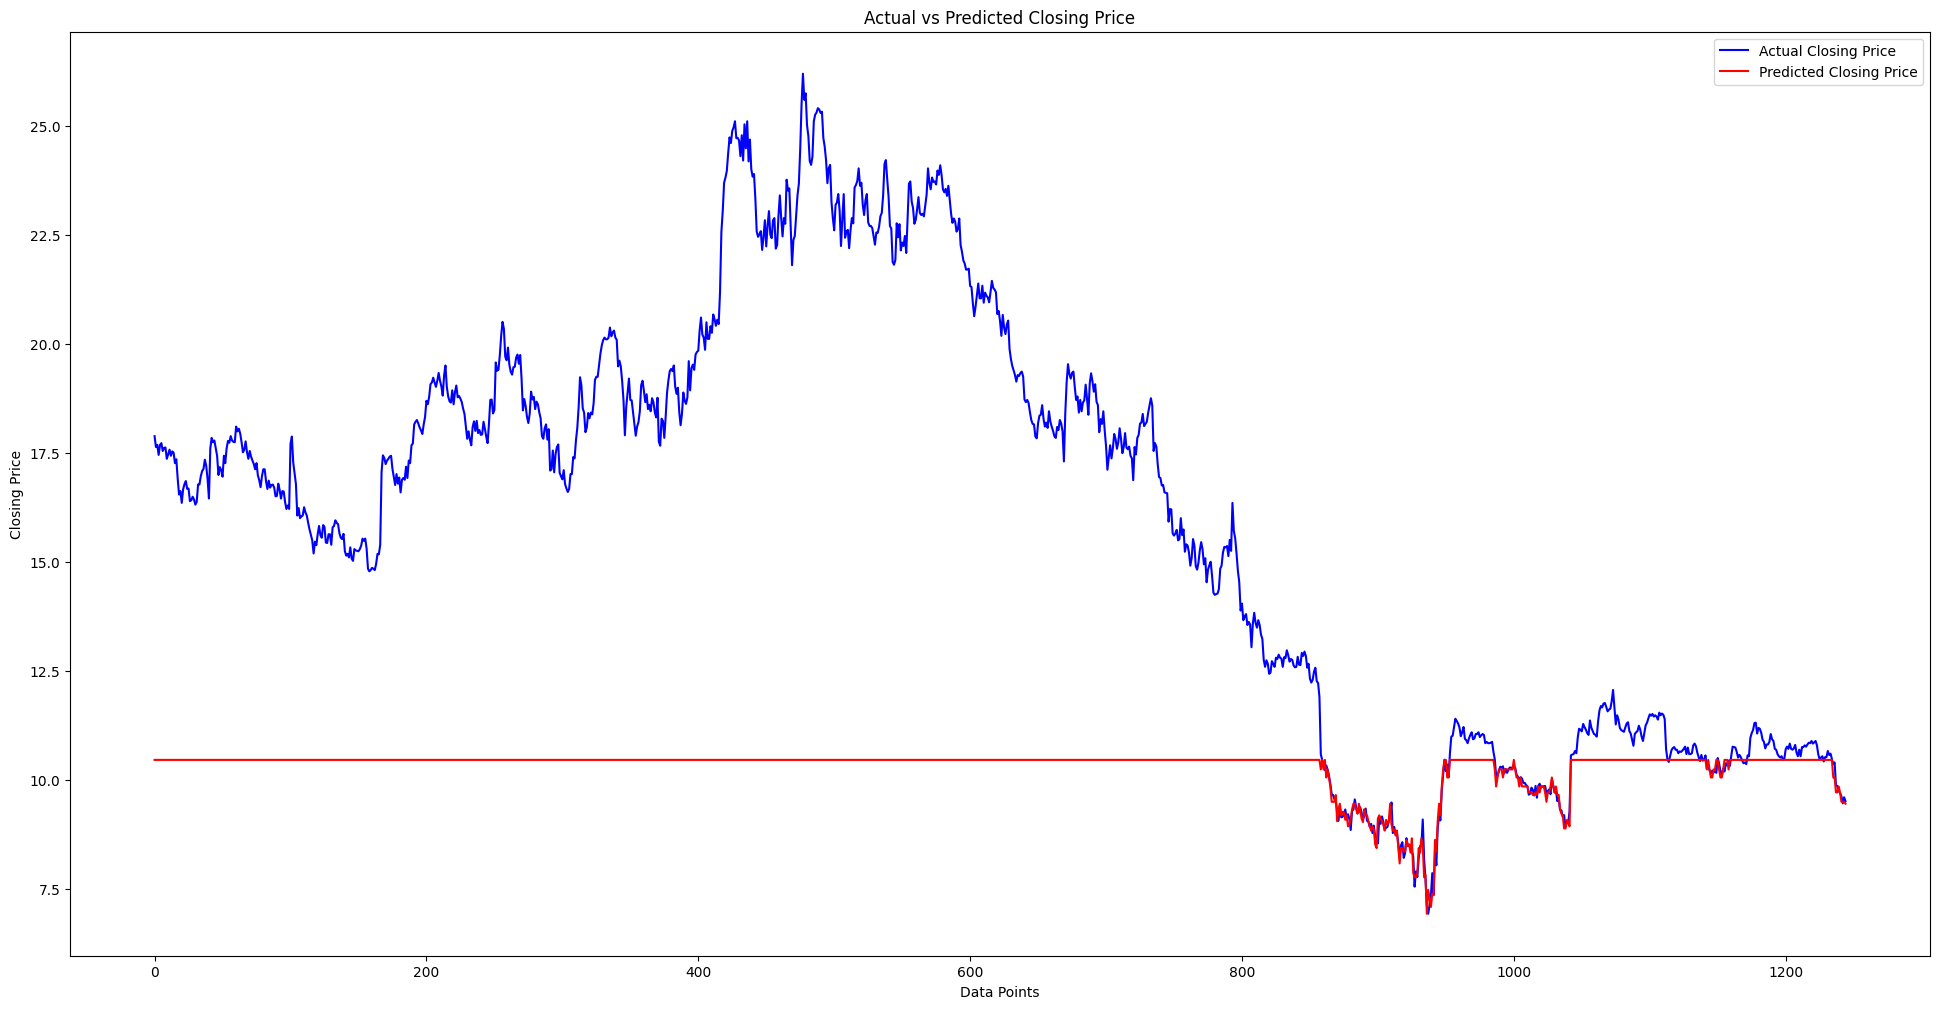

In [105]:
plt.figure(figsize=(24, 12))
plt.plot(actual_values_xg.values, label="Actual Closing Price", color="blue")
plt.plot(predicted_values_xg, label="Predicted Closing Price", color="red")
plt.xlabel("Data Points")
plt.ylabel("Closing Price")
plt.title("Actual vs Predicted Closing Price")
plt.legend()
plt.show()

# Sentiment Analysis

Before working with trained prepare data, lets have a look at market sentiment for this company

In [106]:
file_path = '/content/Nifty_sector.csv'

# Read the CSV file into a Spark DataFrame
company_df = spark.read.csv(file_path, header=True, inferSchema=True)

# Get company name in 'symbol' variable
symbols = company_df.select(col("Symbol")).rdd.flatMap(lambda x: x).collect()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_symbol(symbol):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{symbol} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Not possible download article from {url} due to copyright restriction")

    return None

# Analyze sentiment for the symbols
results = []
for symbol in symbols:
  sentiment = analyze_sentiment_for_symbol(symbol)
  if sentiment:
      result_entry = {"Symbol":symbol.upper(), "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Symbol": symbol.upper(), "Sentiment": "Not found"}
      results.append(result_entry)

# Define the schema for the company sentiment DataFrame
schema = StructType([
    StructField("Symbol", StringType(), True),
    StructField("Sentiment", StringType(), True),
])

# Create the DataFrame
stock_sentiments = spark.createDataFrame(results, schema=schema)

stock_sentiments.show()

Not possible download article from https://www.barrons.com/market-data/stocks/infy due to copyright restriction
Not possible download article from https://www.aaii.com/sentimentsurvey due to copyright restriction
Not possible download article from https://www.barrons.com/market-data/stocks/rdy due to copyright restriction
Not possible download article from https://www.aaii.com/sentimentsurvey due to copyright restriction
+----------+---------+
|    Symbol|Sentiment|
+----------+---------+
|  HDFCBANK| Positive|
|      INFY| Positive|
|       ITC| Positive|
|BHARTIARTL| Positive|
|     TITAN| Positive|
| TATASTEEL| Positive|
|ULTRACEMCO| Positive|
|      NTPC| Positive|
|ADANIPORTS| Positive|
|      ONGC| Positive|
|   DRREDDY| Positive|
| EICHERMOT| Positive|
|       UPL| Positive|
+----------+---------+



Now, lets have a look at market sentiment for these sectors

In [107]:
# Get Industry names in 'Industry' variable
sectors = company_df.select("Industry").distinct().rdd.flatMap(lambda x: x).collect()

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

def fetch_article_text(url):
    ''' This function fetchs article text from a webpage using newspaper3k '''
    article = Article(url)
    article.download()
    article.parse()
    return article.text

def analyze_sentiment_for_sector(sector):
    ''' This function is to analyze sentiment for news headlines for a given symbol '''
    query = f"{sector} independent market sentiment"

    # Perform a Google search and get the first result
    for url in search(query, num_results=10):
        try:
            # Fetch the article text from the webpage
            article_text = fetch_article_text(url)

            # Perform sentiment analysis on the article text
            sentiment_score = sia.polarity_scores(article_text)['compound']

            # Classify overall sentiment as positive, negative, or neutral
            overall_sentiment = 'Positive' if sentiment_score > 0 else 'Negative' if sentiment_score < 0 else 'Neutral'

            return overall_sentiment
        except ArticleException as e:
            print(f"Not possible download article from {url} due to copyright restriction")

    return None

# Analyze sentiment for the symbols
results = []
for sector in sectors:
  sentiment = analyze_sentiment_for_sector(sector)
  if sentiment:
      result_entry = {"Industry":sector, "Sentiment": sentiment}
      results.append(result_entry)

  else:
      result_entry = {"Industry": sector, "Sentiment": "Not found"}
      results.append(result_entry)

# Define the schema for the sector sentiment DataFrame
schema = StructType([
    StructField("Industry", StringType(), True),
    StructField("Sentiment", StringType(), True),
])


# Create a DataFrame from the results list
industry_sentiments = spark.createDataFrame(results, schema=schema)

industry_sentiments.show()

Not possible download article from https://www.aaii.com/sentimentsurvey due to copyright restriction
Not possible download article from https://www.thestreet.com/dictionary/m/market-sentiment due to copyright restriction
Not possible download article from https://www.reuters.com/markets/europe/crude-oil-fuels-draw-funds-sentiment-shifts-2023-08-07/ due to copyright restriction
Not possible download article from https://www.aaii.com/sentimentsurvey due to copyright restriction
Not possible download article from https://www.cairn.info/revue-finance-2017-2-page-7.htm due to copyright restriction
+--------------------+---------+
|            Industry|Sentiment|
+--------------------+---------+
|            Services| Positive|
|           Oil & Gas| Positive|
|     Metals & Mining| Positive|
|   Telecommunication| Positive|
|  Financial Services| Positive|
|               Power| Positive|
|          Healthcare| Positive|
|                FMCG|  Neutral|
|Information Techn...| Positive|
|Con

Join both and create a relevant dataframe for sentiment analysis

In [108]:
# Join the DataFrames on the common columns
joined_df = company_df.alias("company").join(stock_sentiments.alias("stock"), col("company.Symbol") == col("stock.Symbol")).join(industry_sentiments.alias("industry"), col("company.Industry") == col("industry.Industry"))

# Define the logic for the 'Sentiment' column
joined_df = joined_df.withColumn(
    "Final_sentiment",
    when(
        (col("stock.Sentiment") == "Positive") & (col("industry.Sentiment") == "Positive"),
        "Positive"
    ).when(
        (col("stock.Sentiment") == "Negative") & (col("industry.Sentiment") == "Negative"),
        "Negative"
    ).when(
        (col("stock.Sentiment") == "Positive") & (col("industry.Sentiment") == "Negative"),
        "Neutral"
    ).when(
        (col("stock.Sentiment") == "Negative") & (col("industry.Sentiment") == "Positive"),
        "Neutral"
    ).otherwise("Neutral")
)


# Select only the relevant columns
final_sentiment_df = joined_df.select(
    col("company.Symbol").alias("Symbol"),
    col("company.Industry").alias("Industry"),
    col("Final_sentiment")
)

# Show the final DataFrame
final_sentiment_df.show()

+----------+--------------------+---------------+
|    Symbol|            Industry|Final_sentiment|
+----------+--------------------+---------------+
| EICHERMOT|          Automobile|       Positive|
|       UPL|           Chemicals|       Positive|
|ULTRACEMCO|Construction Mate...|       Positive|
|     TITAN|   Consumer Durables|        Neutral|
|       ITC|                FMCG|        Neutral|
|  HDFCBANK|  Financial Services|       Positive|
|   DRREDDY|          Healthcare|       Positive|
|      INFY|Information Techn...|       Positive|
| TATASTEEL|     Metals & Mining|       Positive|
|      ONGC|           Oil & Gas|       Positive|
|      NTPC|               Power|       Positive|
|ADANIPORTS|            Services|       Positive|
|BHARTIARTL|   Telecommunication|       Positive|
+----------+--------------------+---------------+



Linear Regression emerged as clear winner here. Hence we will conclude the project with linear regression.

In [109]:
from pyspark.sql.functions import monotonically_increasing_id
from pyspark.sql.functions import from_unixtime, col
from pyspark.sql.types import TimestampType
from pyspark.sql.functions import lit

# Create a LinearRegression object
lin_reg = LinearRegression(labelCol='Close', maxIter=10, regParam=0.3, elasticNetParam=0.8)

# Train the model
model = lin_reg.fit(training_data)

# Make predictions on the testing data
predictions = model.transform(testing_data)

# extract the "prediction" column
predictions = predictions.select("prediction").collect()

# Convert the predictions to a list
prediction_list = [row["prediction"] for row in predictions]

# Create a Pandas DataFrame from the list
lin_df_test = pd.DataFrame(data=prediction_list, columns=["Predicted_close"])

# Convert the Pandas DataFrame to a Spark DataFrame
spark_df_test = spark.createDataFrame(lin_df_test)

# Add unique IDs to each DataFrame
spark_df_test_with_id = spark_df_test.withColumn("id", monotonically_increasing_id())
testing_data_with_id = testing_data.withColumn("id", monotonically_increasing_id())

# Perform an inner join based on the generated IDs
merged_df = testing_data_with_id.join(spark_df_test_with_id, "id", "inner").drop("id")

# Convert the timestamp to a human-readable format
merged_df = merged_df.withColumn("Date", from_unixtime(col("Date").cast("long")).cast(TimestampType()))

# Select 'Final_sentiment' for 'INFY' from final_sentiment_df
infy_sentiment = final_sentiment_df.filter(col("Symbol") == "INFY").select("Final_sentiment").collect()[0]["Final_sentiment"]

# Map 'Final_sentiment' to 'Recommendation'
recommendation_mapping = {"Positive": "Buy", "Negative": "Sell", "Neutral": "Hold"}
infy_recommendation = recommendation_mapping.get(infy_sentiment, "Unknown")

# Add 'Final_sentiment' and 'Recommendation' columns to merged_df
merged_df = merged_df.withColumn("Final_sentiment", lit(infy_sentiment))
merged_df = merged_df.withColumn("Recommendation", lit(infy_recommendation))

# Show the merged DataFrame
selected_columns = ["Date", "Open", "Close", "Adj Close", "Predicted_close", "Final_sentiment", "Recommendation"]
merged_df.select(selected_columns).show()


+-------------------+------------------+------------------+------------------+------------------+---------------+--------------+
|               Date|              Open|             Close|         Adj Close|   Predicted_close|Final_sentiment|Recommendation|
+-------------------+------------------+------------------+------------------+------------------+---------------+--------------+
|2023-12-08 00:00:00|17.889999389648438|17.889999389648438|17.889999389648438|  16.4052212669472|       Positive|           Buy|
|2023-12-07 00:00:00|17.670000076293945|17.639999389648438|17.639999389648438|  16.2116987730713|       Positive|           Buy|
|2023-12-06 00:00:00|17.799999237060547|17.690000534057617|17.690000534057617| 16.32605259267977|       Positive|           Buy|
|2023-12-05 00:00:00| 17.59000015258789|17.459999084472656|17.459999084472656| 16.14132680458915|       Positive|           Buy|
|2023-12-04 00:00:00| 17.84000015258789|17.690000534057617|17.690000534057617|16.361239415820883|

Create a managed database to store the data

In [110]:
spark.sql("DROP DATABASE IF EXISTS stock_db CASCADE")
spark.sql("CREATE DATABASE stock_db")
spark.sql("USE stock_db")

DataFrame[]

In [111]:
from pyspark.sql.functions import date_format
# Convert merged_df file to a csv
output_file_name = "/content/merged_df"

## Convert the date to a string
merged_df_new = merged_df.withColumn("Date", date_format("Date", "yyyy-MM-dd"))

merged_df_new.select(selected_columns).write.csv(
    output_file_name,
    header=False,
    mode="overwrite"
)
new_name = "stock.csv"
!cp {output_file_name}/part-00000* {new_name}

In [112]:
# Path to CSV file
csv_file = '/content/stock.csv'

# Define schema
schema="date STRING, Open FLOAT, Close FLOAT, Adj_Close FLOAT, Predicted_close FLOAT, Final_sentiment STRING, Recommendation STRING"

# Create a temporary df
stock_df = spark.read.csv(csv_file, schema=schema)

# Write into table
spark.sql("DROP TABLE IF EXISTS stock_tbl")
stock_df.write.saveAsTable("stock_tbl")

In [113]:
# Create a global view
df_stock = spark.sql("SELECT * FROM stock_tbl")
df_stock.createOrReplaceGlobalTempView("stock_tmp_view")

In [114]:
# Read from the global view
spark.sql("SELECT * FROM global_temp.stock_tmp_view").show()

+----------+-----+-----+---------+---------------+---------------+--------------+
|      date| Open|Close|Adj_Close|Predicted_close|Final_sentiment|Recommendation|
+----------+-----+-----+---------+---------------+---------------+--------------+
|2023-12-08|17.89|17.89|    17.89|      16.405222|       Positive|           Buy|
|2023-12-07|17.67|17.64|    17.64|      16.211699|       Positive|           Buy|
|2023-12-06| 17.8|17.69|    17.69|      16.326052|       Positive|           Buy|
|2023-12-05|17.59|17.46|    17.46|      16.141327|       Positive|           Buy|
|2023-12-04|17.84|17.69|    17.69|      16.361238|       Positive|           Buy|
|2023-12-01|17.47|17.73|    17.73|      16.035769|       Positive|           Buy|
|2023-11-30|17.61|17.55|    17.55|       16.15892|       Positive|           Buy|
|2023-11-29|17.74|17.62|    17.62|      16.273273|       Positive|           Buy|
|2023-11-28|17.37|17.63|    17.63|      15.947804|       Positive|           Buy|
|2023-11-27|17.3

# ARIMA


In [115]:
# Stationarity is key to underdstand is data is asuitable for time series forcasting

def stationarity(df, var):
    df['rollMean'] = df[var].rolling(window=3).mean()
    df['rollStd'] = df[var].rolling(window=3).std()

    from statsmodels.tsa.stattools import adfuller
    adfTest = adfuller(df[var], autolag = 'AIC')
    stats= pd.Series(adfTest[0:4], index = ['Test Statistics', 'p-value', '#lags used', 'numbers of observations used'])
    print(stats)
    for key,values in adfTest[4].items():
        print("criticality",key,":",values)

    sns.lineplot( data = df, x = df.index, y = var, label = "Original")
    sns.lineplot( data = df, x = df.index, y = 'rollMean', label = "Mean")
    sns.lineplot( data = df, x = df.index, y = 'rollStd', label = "Variance")

Test Statistics                   -0.769925
p-value                            0.827797
#lags used                        33.000000
numbers of observations used    6195.000000
dtype: float64
criticality 1% : -3.4314060147981067
criticality 5% : -2.8620066641642783
criticality 10% : -2.5670184024907483


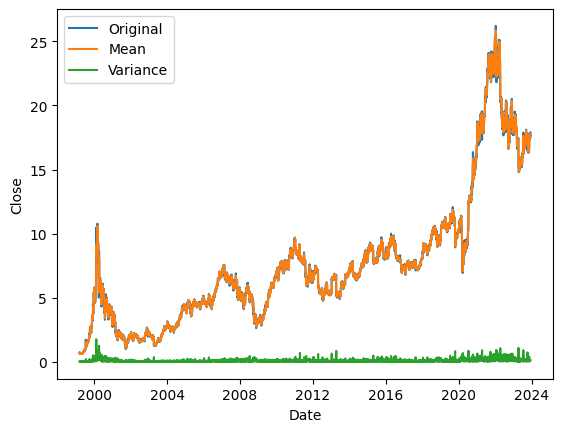

In [116]:
stationarity(data, "Close")

In [117]:
# Convert Non- Stationary data to stationary data
# Method 1 - Time shift
air_df = data[['Close']]

air_df['shift'] = air_df.Close.shift()
air_df['shiftDiff'] = air_df.Close - air_df['shift']


# Method 2 - Log value
air_df['log'] = np.log(data['Close'])


air_df.head()

<ipython-input-117-43ba6878d379>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df['shift'] = air_df.Close.shift()
<ipython-input-117-43ba6878d379>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  air_df['shiftDiff'] = air_df.Close - air_df['shift']
<ipython-input-117-43ba6878d379>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas

,Close,shift,shiftDiff,log
Date,,,,
1999-03-11,0.732422,NaN,NaN,-0.311398
1999-03-12,0.728516,0.732422,-0.003906,-0.316746
1999-03-15,0.662109,0.728516,-0.066407,-0.412325
1999-03-16,0.656250,0.662109,-0.005859,-0.421213
1999-03-17,0.660156,0.656250,0.003906,-0.415279


<ipython-input-115-52d1711a49a6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollMean'] = df[var].rolling(window=3).mean()
<ipython-input-115-52d1711a49a6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rollStd'] = df[var].rolling(window=3).std()


Test Statistics                -1.582861e+01
p-value                         1.000483e-28
#lags used                      3.400000e+01
numbers of observations used    6.193000e+03
dtype: float64
criticality 1% : -3.431406355974594
criticality 5% : -2.8620068149070077
criticality 10% : -2.5670184827348006


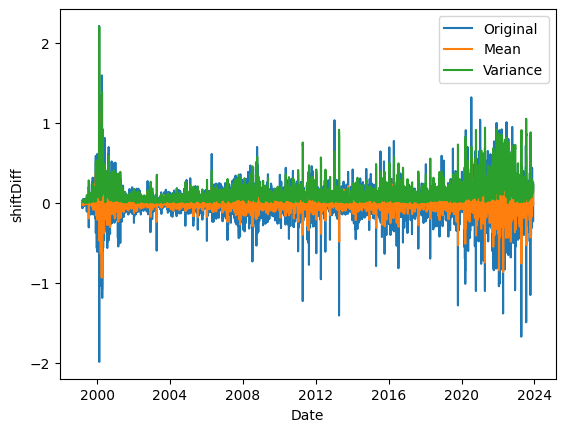

In [118]:
stationarity(air_df.dropna(), "shiftDiff")

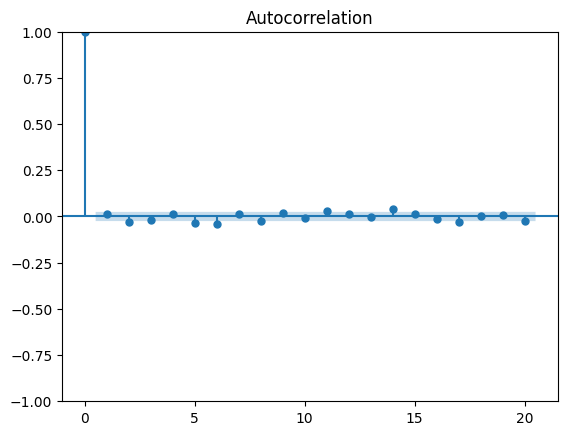

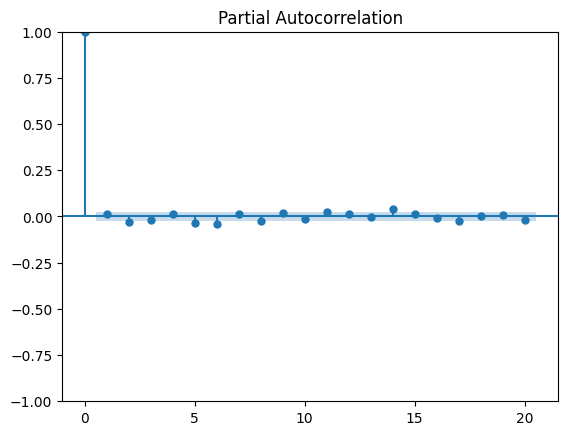

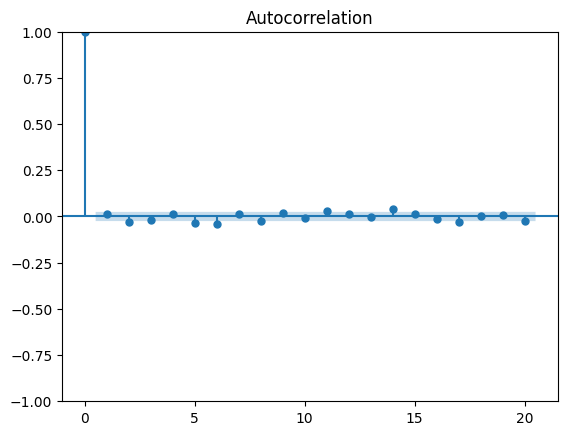

In [119]:

#creating a new DataFrame that contains only the 'Close' column
df_Stocks_Close = air_df[['Close']].copy(deep=True)

# First Diff - commonly used to make the time series data stationary, for ARIMA models.
df_Stocks_Close['firstDiff'] = df_Stocks_Close['Close'].diff()

# Seasonal Difference - by subtracting the value from 12 months ago from the current value.
# useful for addressing seasonality in the data
df_Stocks_Close['Diff12'] = df_Stocks_Close['Close'].diff(12)

# Order for ARIMA - p value using PACF
plot_pacf(df_Stocks_Close['firstDiff'].dropna(), lags=20) #why lags is 20 ?
# Order for ARIMA - qvalue using ACF
plot_acf(df_Stocks_Close['firstDiff'].dropna(), lags=20) #why lags is 20 ?

In [120]:
df_Stocks_Close.reset_index(inplace= True)
print(len(df_Stocks_Close))

#Train &  test Set
train = df_Stocks_Close[: round(len(df_Stocks_Close)*0.99)]  # starting to 99% value
test = df_Stocks_Close[round(len(df_Stocks_Close)*0.99):]       # from 1% till end


print("Training data size:", len(train))
print("Testing data size:", len(test))

# Manually train ARIMA on the training data
order = (6, 1, 6)  # You may need to adjust the order based on your data characteristics

model = ARIMA(train['Close'], order=order)
model_fit = model.fit()

# Make predictions on the test data
predictions = model_fit.predict(start=test.index[0], end=test.index[-1])

df_Stocks_Close["arimaPred"] = predictions

# Display predictions
df_Stocks_Close.tail()

6229
Training data size: 6167
Testing data size: 62


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


,Date,Close,firstDiff,Diff12,arimaPred
6224,2023-12-04,17.690001,-0.039999,0.330000,18.044998
6225,2023-12-05,17.459999,-0.230001,0.189999,18.043816
6226,2023-12-06,17.690001,0.230001,0.180000,18.040616
6227,2023-12-07,17.639999,-0.050001,0.099998,18.035434
6228,2023-12-08,17.889999,0.250000,0.449999,18.035022


In [121]:
RMSE_ARIMA = np.sqrt(mean_squared_error(test['Close'], predictions))
print(RMSE_ARIMA)

0.9362219506040915


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


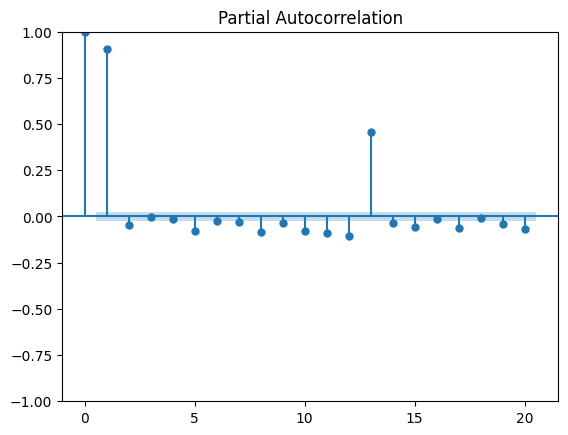

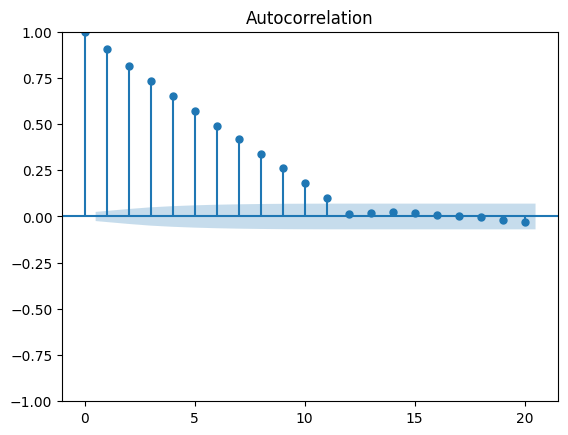

In [122]:
# Order for SARIMAX - p value using PACF
# Order for SARIMAX - q value using ACF

plot_pacf(df_Stocks_Close['Diff12'].dropna(), lags=20)
plot_acf(df_Stocks_Close['Diff12'].dropna(), lags=20)


# Training SARIMAX
model1 = SARIMAX(train['Close'], order=(6, 1, 6), seasonal_order=(1,1,6,12))

model_fit1 = model1.fit()

prediction1 = model_fit1.predict(start= test.index[0] , end = test.index[-1])


df_Stocks_Close['sarimaxPred'] = prediction1

<Axes: ylabel='Close'>

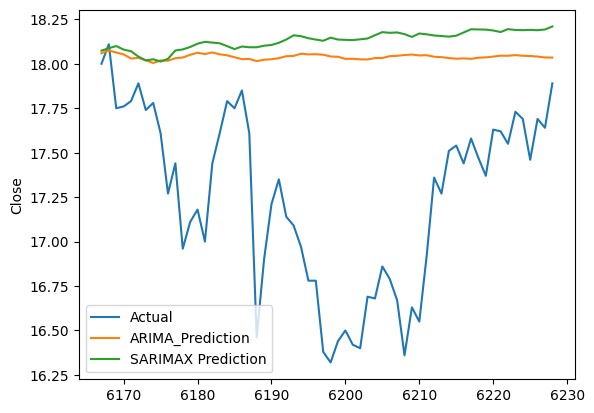

In [123]:
df_Stocks_Close1= df_Stocks_Close[round(len(df_Stocks_Close)*0.99):]
df_Stocks_Close.dropna()
sns.lineplot( data = df_Stocks_Close1, x = df_Stocks_Close1.index , y = df_Stocks_Close1['Close'], label = "Actual")
sns.lineplot( data = df_Stocks_Close1, x = df_Stocks_Close1.index , y = df_Stocks_Close1['arimaPred'],  label = "ARIMA_Prediction")
sns.lineplot( data = df_Stocks_Close1, x = df_Stocks_Close1.index , y = df_Stocks_Close1['sarimaxPred'], label = "SARIMAX Prediction")

In [124]:
mse = mean_squared_error(test['Close'], prediction1)
rmse = sqrt(mean_squared_error(test['Close'], prediction1))
r2 = r2_score(test['Close'], prediction1)
mae = mean_absolute_error(test['Close'], prediction1)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R2 score: {r2}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 1.0458051435936127
Root Mean Squared Error (RMSE): 1.0226461477919
R2 score: -3.261480688982906
Mean Absolute Error (MAE): 0.8881237190810868
